In [2]:
# # Jupyter notebook에서 여러 개의 output 출력
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = 'all'

In [2]:
from folium.plugins import MarkerCluster
from folium import plugins
import folium

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json

In [3]:
# JSON 파일 불러오기
json_file = 'PRE_TL_SCCO_SIG.json'

# UTF-8 인코딩으로 JSON 로딩하기
korea_geo = json.load(open(json_file, encoding='UTF-8'))

In [4]:
df_road_data = pd.read_csv('preprocessed_csv/ROAD_DATA.csv')

In [5]:
# 전처리한 새로운 csv 파일 불러오기
preprocessed_df_tailgate = pd.read_csv('preprocessed_csv/df_tailgate.csv')
preprocessed_df_illegal_u_turn = pd.read_csv('preprocessed_csv/df_illegal_u_turn.csv')
preprocessed_df_illegal_left_turn = pd.read_csv('preprocessed_csv/df_illegal_left_turn.csv')
preprocessed_df_signal_violation = pd.read_csv('preprocessed_csv/df_signal_violation.csv')
preprocessed_df_wrong_way_driving = pd.read_csv('preprocessed_csv/df_wrong_way_driving.csv')
preprocessed_df_stop_line_violation = pd.read_csv('preprocessed_csv/df_stop_line_violation.csv')
preprocessed_df_center_line_violation = pd.read_csv('preprocessed_csv/df_center_line_violation.csv')
preprocessed_df_designated_lane_violation = pd.read_csv('preprocessed_csv/df_designated_lane_violation.csv')
preprocessed_df_improper_lane_change = pd.read_csv('preprocessed_csv/df_improper_lane_change.csv')

# 모든 데이터 프레임 일괄 저장용 리스트: (이름, 데이터프레임)
preprocessed_all_name_N_df = [
    ('꼬리물기', preprocessed_df_tailgate),
    ('불법 유턴', preprocessed_df_illegal_u_turn),
    ('불법 좌회전', preprocessed_df_illegal_left_turn),
    ('신호 위반', preprocessed_df_signal_violation),
    ('역주행', preprocessed_df_wrong_way_driving),
    ('정지선 침범', preprocessed_df_stop_line_violation),
    ('중앙선 침범', preprocessed_df_center_line_violation),
    ('지정 차로 위반', preprocessed_df_designated_lane_violation),
    ('진로 변경 위반', preprocessed_df_improper_lane_change)
]

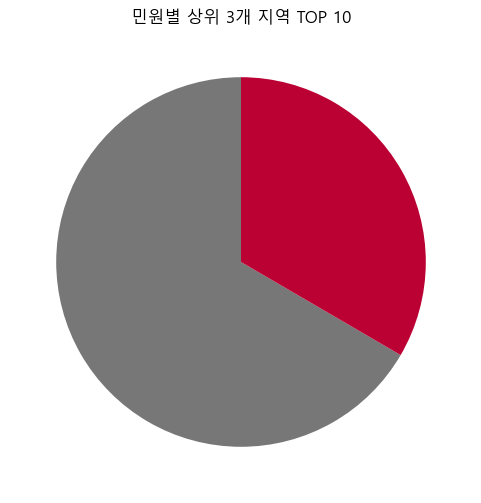

In [39]:
top3_region = []
top3_count  = []
top_region = []
top_count = []

# 전처리한 각 데이터프레임에서, 최대 밀집 구역과 값 찾기
for name, df in preprocessed_all_name_N_df:
    g = df.groupby('지역')

    # 변수 초기화
    max_region_count = []

    # Grouping한 데이터프레임에서 최대 민원 개수를 기준
    # 상위 3개 구역 찾기
    for region, coord in g:
        # (region, count)
        max_region_count.append((region, len(coord)))
        
    max_region_count.sort(key = lambda x: -x[1])

    # 상위 3개 지역 저장하기
    for i in range(3):
        top3_region.append(name + "\n" + max_region_count[i][0])
        top3_count.append(max_region_count[i][1])

        top_region.append(max_region_count[i][0])
        top_count.append(max_region_count[i][1])

# 그래프용 데이터프레임
top3_df = pd.DataFrame({"top3_region": top3_region, "top3_count": top3_count})
top3_df = top3_df.sort_values(
    by = ['top3_count'],
    ascending = [False]
)

# top3 그래프 그리기
plt.figure(figsize = (6, 6))
plt.rc('font', family='Malgun Gothic')
plt.title("민원별 상위 3개 지역 TOP 10")

#colors = ["#990033"]
#sns.set_palette(sns.color_palette(colors))
#sns.barplot(y = "top3_count", x = "top3_region", data = top3_df.head(10), palette = colors)


ratio = [66.6, 33.4] # [3, 3, 3, 1]
labels = ['진로 변경 방법 위반', '신호 위반', '불법 좌회전', '역주행']
colors = ['#777777', '#BB0033'] # ['#880033', '#777777', '#AA0033', '#990033']
plt.pie(ratio, colors=colors, startangle = 90)
# wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}

# plt.pie(ratio, labels=labels, autopct='%.1f%%', startangle=260, counterclock=False, colors=colors, wedgeprops=wedgeprops)
plt.show()

In [7]:
check_data = [
    [preprocessed_df_improper_lane_change, "화성시"],
    [preprocessed_df_signal_violation, "화성시"],
    [preprocessed_df_improper_lane_change, "용인시수지구"],
    [preprocessed_df_improper_lane_change, "안동시"],
    [preprocessed_df_signal_violation, "평택시"],
    [preprocessed_df_illegal_left_turn, "화성시"],
    [preprocessed_df_illegal_left_turn, "파주시"],
    [preprocessed_df_signal_violation, "시흥시"],
    [preprocessed_df_illegal_left_turn, "용인시수지구"],
    [preprocessed_df_wrong_way_driving, "대전광역시 서구"],   
]

In [8]:
# folium.Map(location= [위도, 경도], zoom_start= 지도_배율)
# 1배율: 세계_지도, 5배율: 대한민국_지도
draw_map = folium.Map(
    [37.54811169065214, 126.942004340589],
    zoom_start= 20,
    tiles='cartodbpositron',
)

# JSON으로 나눈 구역을 folium으로 그리기
folium.GeoJson(
    korea_geo,
    name = '시군구',
).add_to(draw_map)

In [10]:
mc = MarkerCluster()

for i, each_row in enumerate(preprocessed_df_signal_violation.iloc):
    line_number = each_row[0]
    latitude = each_row[2]
    longitude = each_row[3]
    region = each_row[4]

    # Polygon에서 특정 지역만을 탐색
    if region == '화성시':
        folium.Marker(
            location = [latitude, longitude],
            popup = line_number
        ).add_to(mc)

        # 위에서 i번째 행 데이터프레임 형태로 출력
        # print(all_name_N_df[0][1].loc[[i]])

mc.add_to(draw_map)

In [10]:
draw_map

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [12]:
from math import log

tmp = []

for i in df_road_data.iloc():
    tmp.append(log(i[5]))

df_road_data['log'] = tmp

df_road_data.head()

,도로명,색상,종속변수 - 공용이후 재귀반사도,독립변수 - 시공초기 재귀 반사도,독립변수 - 공용기간(개월),"독립변수 - 일교통량(대, 방향별)",log
0,신촌로A,백색,96,261,18,21508,9.976180
1,신촌로B,백색,140,340,18,21508,9.976180
2,신촌로C,백색,119,396,18,14994,9.615405
3,신촌로D,백색,119,271,18,14994,9.615405
4,신촌로E,백색,132,338,18,34693,10.454293


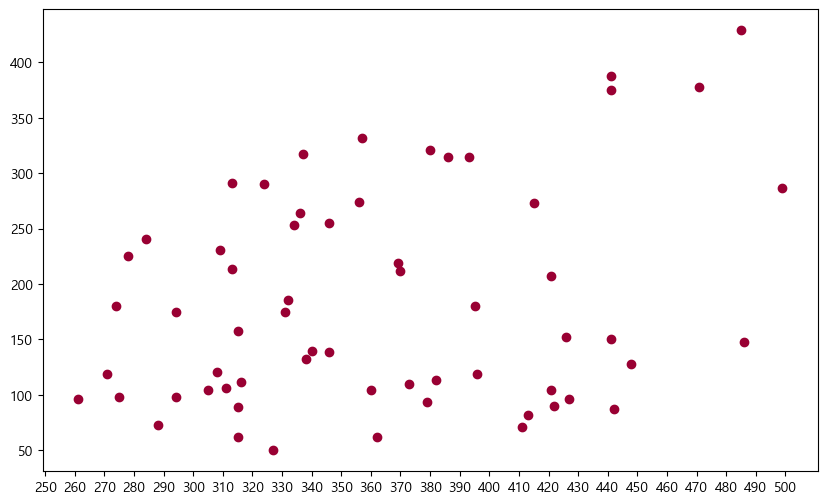

In [13]:
plt.figure(figsize = (10, 6))
plt.scatter(df_road_data['독립변수 - 시공초기 재귀 반사도'], df_road_data['종속변수 - 공용이후 재귀반사도'])
plt.xticks(np.arange(250, 510, 10))
plt.show()

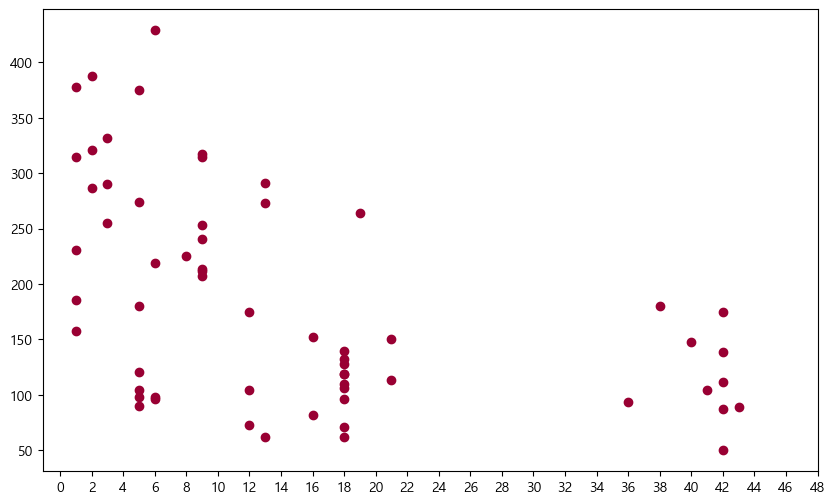

In [14]:
plt.figure(figsize = (10, 6))
plt.scatter(df_road_data['독립변수 - 공용기간(개월)'], df_road_data['종속변수 - 공용이후 재귀반사도'])
plt.xticks(np.arange(0, 50, 2))
plt.show()

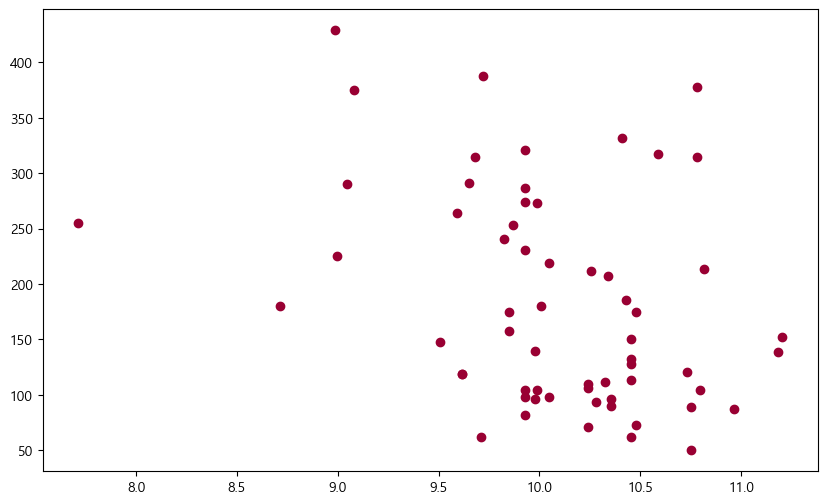

In [15]:
plt.figure(figsize = (10, 6))
# plt.scatter(df_road_data['독립변수 - 일교통량(대, 방향별)'], df_road_data['종속변수 - 공용이후 재귀반사도'])
plt.scatter(df_road_data['log'], df_road_data['종속변수 - 공용이후 재귀반사도'])
plt.show()

In [16]:
x = df_road_data[['독립변수 - 시공초기 재귀 반사도', '독립변수 - 공용기간(개월)', 'log']]
y = df_road_data[['종속변수 - 공용이후 재귀반사도']]

lr = LinearRegression()
lr.fit(x, y)

LinearRegression()

In [17]:
lr.coef_    # array([[ 5.31764602e-01, -3.43765156e+00, -1.05857547e-03]])

array([[  0.53757707,  -3.28491629, -37.50180771]])

In [18]:
lr.intercept_    # array([71.56328525])

array([415.65848347])

In [22]:
# 논문 연구 자료 방정식
# Rf = (0.537 * Rfo) - (86.967 * ADT) - (3.277 * Time) + 418.339

# 직접 실행한 회귀 분석 방정식
# Rf = (0.53757707 * Rfo) - (37.50180771 * ADT) - (3.28491629 * Time) + 415.65848347

# Rf = 재귀 반사 성능: 최소 기준 100
# Rfo = 시공 초기 재귀 반사도: 최소 기준 250
# ADT = 일 평균 교통량
# Time = 공용 기간(개월)

from math import log

ADT, Time = [], []

for adt in range(10000, 100001, 10000):
    time = 0 
    while True:
        if (0.53757707 * 250) - (37.50180771 * log(adt)) - (3.28491629 * time) + 415.65848347 < 100:
            ADT.append(adt)
            Time.append(time)
            break
        else:
            time += 1

print(f'ADT: {ADT}')
print(f'Time: {Time}')

ADT: [10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000]
Time: [32, 24, 20, 17, 14, 12, 10, 9, 7, 6]


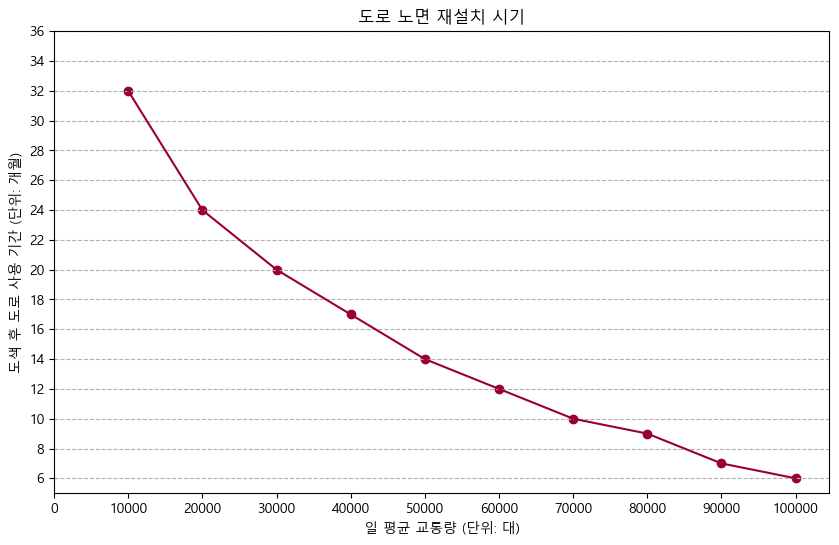

In [52]:
plt.figure(figsize = (10, 6))
plt.plot(ADT, Time)
plt.scatter(ADT, Time)

plt.xlabel('일 평균 교통량 (단위: 대)')
plt.xticks(np.arange(0, 100001, 10000))

plt.ylabel('도색 후 도로 사용 기간 (단위: 개월)')
plt.yticks(np.arange(0, 50, 2))
plt.ylim(5, 36)

plt.grid(axis = 'y', linestyle = '--')
plt.title("도로 노면 재설치 시기")
plt.show()